# Bináris szegmentáció előtanított mélyháló felhasználásával

Az adathalmazt törölnöm kellett


In [3]:
import os
import tarfile
import PIL
from PIL import Image
import io

import matplotlib.pyplot as plt
import matplotlib.patches
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
import tensorflow.keras.optimizers

In [ ]:
!wget -n dataset.tar

In [5]:
jpg_ims = []
label_ims = []

# unpacking tar content directly into memory and decoding jpg/png images from there to avoid working with many small files on disk
with tarfile.open("dataset.tar", "r") as tar:
    tar_members = tar.getmembers()
    tar_jpg_members = [member for member in tar_members if member.name[-4:] == '.jpg']  # list only jpg images, not label images
    for jpg_member in tar_jpg_members:
        filename_noext = os.path.split(jpg_member.name)[-1][:-4]

        # get next jpg image
        file_in_tar = tar.extractfile(jpg_member)
        byte_arr = np.asarray(bytearray(file_in_tar.read()), dtype=np.uint8)
        pil_image = Image.open(io.BytesIO(byte_arr))
        npy_image = np.asarray(pil_image)
        assert npy_image.dtype == np.uint8
        jpg_ims.append(npy_image)

        # get label image corresponding to the jpg image
        label_member_name = 'dataset/SegmentationClass/' + filename_noext + '.png'
        file_in_tar = tar.extractfile(label_member_name)
        byte_arr = np.asarray(bytearray(file_in_tar.read()), dtype=np.uint8)
        pil_image = Image.open(io.BytesIO(byte_arr))  # using PIL instead of cv2 as it supports loading palette coded png images as single channel integer arrays
        npy_image = np.asarray(pil_image)
        assert npy_image.dtype == np.uint8
        label_ims.append(npy_image)

jpg_ims = np.stack(jpg_ims, axis=0)
label_ims = np.stack(label_ims, axis=0)

# removing 'border region' (255) from label images and replacing it with background (0)
label_ims[label_ims == 255] = 0

print("Image & label data was loaded into 'jpg_ims', 'label_ims' NumPy arrays. Shapes:", jpg_ims.shape, label_ims.shape)

Image & label data was loaded into 'jpg_ims', 'label_ims' NumPy arrays. Shapes: (2913, 240, 320, 3) (2913, 240, 320)


In [6]:
ORIG_CAT_NAMES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', \
                  'dining table', 'dog', 'horse', 'motorbike', 'person', 'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

### A madár, macska, kutya, ló és bárány képek különválasztása a többitől.

In [7]:
#B

arr_2d = label_ims.reshape(label_ims.shape[0], -1)

contains_bird=np.any(arr_2d==3,axis=1)
contains_cat=np.any(arr_2d==10,axis=1)
contains_dog=np.any(arr_2d==12,axis=1)
contains_horse=np.any(arr_2d==13,axis=1)
contains_sheep=np.any(arr_2d==17,axis=1)
mask = ~contains_bird & ~contains_cat & ~contains_sheep & ~contains_horse & contains_dog

dog_imgs=np.where(mask)[0]
mask=contains_bird | contains_cat | contains_sheep | contains_horse | contains_dog
no_pet_imgs=np.where(~mask)[0][:dog_imgs.shape[0]//2]

In [8]:
#C

from scipy.ndimage import label
from skimage.measure import regionprops

relevant_idxs=np.concatenate((dog_imgs,no_pet_imgs))
ids=np.array([3,10,12,13,17])
bboxes = []
other_ind=np.setdiff1d(np.arange(len(ORIG_CAT_NAMES)),ids)
other_ind=other_ind[1:]


def get_bounding_box(arr,idx,unique_labels,which):
    bounding_box = []


    for unique_label in unique_labels:

        binary_img = np.where(arr == unique_label, 1, 0)
        labeled_img, num_features = label(binary_img)

        for region in regionprops(labeled_img):
            minr, minc, maxr, maxc = region.bbox
            bounding_box.append([minr, minc, maxr, maxc,which,idx])

    return bounding_box


for idx in relevant_idxs:
    label_im = label_ims[idx]
    uniq=np.unique(label_im)
    k=True
    if np.isin(ids[0],uniq) or np.isin(ids[1],uniq) or np.isin(ids[2],uniq) or np.isin(ids[3],uniq) or np.isin(ids[4],uniq):
      bboxes.extend(get_bounding_box(label_im,idx,ids,1))
      k=False
    if k:
      bboxes.extend(get_bounding_box(label_im,idx,other_ind,0))
bboxes = np.array(bboxes)

tf.keras.utils.set_random_seed(42)

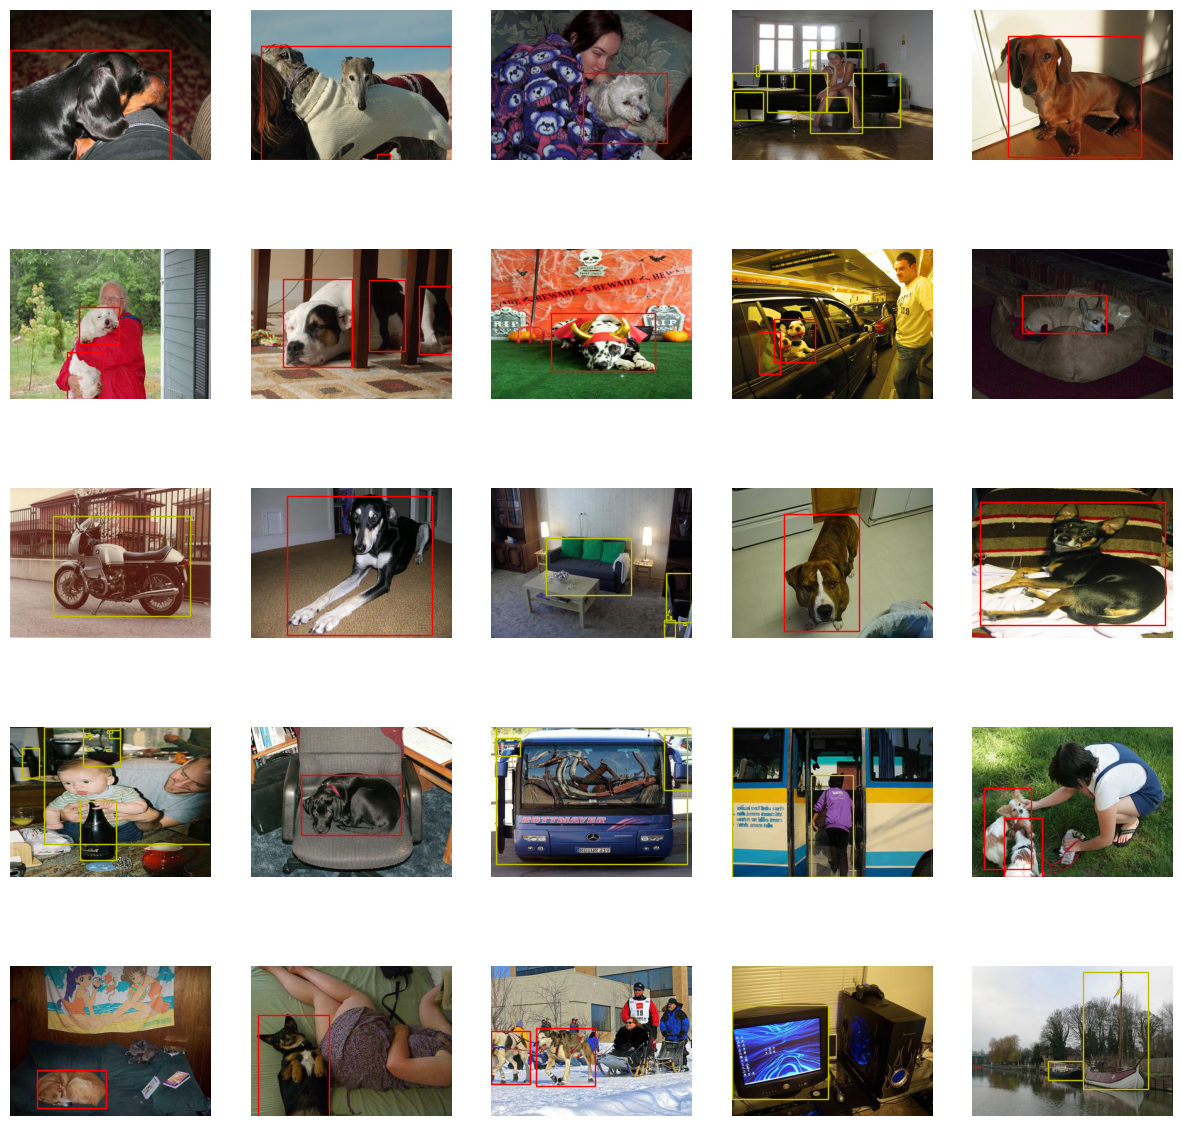

In [9]:
#D

idxes=np.random.choice(relevant_idxs, size=25, replace=False)

where_dog=bboxes[np.where(bboxes[:,4]==1)][:,5]

fig, axs = plt.subplots(5, 5, figsize=(15, 15))
for i in range(25):
  if np.isin(idxes[i],where_dog):
    f=np.where(bboxes[:,5]==idxes[i])[0]
    for j in range(len(f)):
      fx=f[j]
      rect = matplotlib.patches.Rectangle((bboxes[fx][1],bboxes[fx][0]),bboxes[fx][3]-bboxes[fx][1],bboxes[fx][2]-bboxes[fx][0],linewidth=1,edgecolor='r',facecolor='none')
      axs[i//5][i%5].add_patch(rect)
  else:
    f=np.where(bboxes[:,5]==idxes[i])[0]
    for j in range(len(f)):
      fx=f[j]
      rect = matplotlib.patches.Rectangle((bboxes[fx][1],bboxes[fx][0]),bboxes[fx][3]-bboxes[fx][1],bboxes[fx][2]-bboxes[fx][0],linewidth=1,edgecolor='y',facecolor='none')
      axs[i//5][i%5].add_patch(rect)



  axs[i//5][i%5].imshow(jpg_ims[idxes[i]])
  axs[i//5][i%5].axis('off')

### Képek és címkék előkészítése

In [10]:
#E

widths,heights=bboxes[:,3]-bboxes[:,1],bboxes[:,2]-bboxes[:,0]
mask = (widths < 30) | (heights < 30)
drop=np.where(mask)
good=np.arange(bboxes.shape[0])
good=np.setdiff1d(good,drop)
bboxes=bboxes[good]

center_x = (bboxes[:, 3] + bboxes[:, 1]) // 2
center_y = (bboxes[:, 2] + bboxes[:, 0]) // 2

crop_size = 160

x1 = center_x - crop_size // 2
x2 = center_x + crop_size // 2
y1 = center_y - crop_size // 2
y2 = center_y + crop_size // 2

x_lefts = x1 < 0
x_rights = x2 >320
y_downs = y1 < 0
y_ups = y2 > 240

x1[x_lefts]=0
x2[x_lefts]=crop_size
x1[x_rights]=320-crop_size
x2[x_rights]=320
y1[y_downs]=0
y2[y_downs]=crop_size
y1[y_ups]=240-crop_size
y2[y_ups]=240


xs=jpg_ims[bboxes[:,5]]
ys=label_ims[bboxes[:,5]]
box_indices = np.arange(bboxes.shape[0])

crop_size2d = [crop_size, crop_size]
ind=np.array([y1/240,x1/320,y2/240,x2/320])
ind= ind.T
xs = tf.image.crop_and_resize(xs, ind, box_indices, crop_size2d)
ys = tf.expand_dims(ys, axis=-1)
ys = tf.image.crop_and_resize(ys, ind, box_indices, crop_size2d)
ys = tf.squeeze(ys, axis=-1)

ys=np.where(ys != 12, 0, ys)
ys=np.where(ys == 12, 1, ys)


xs=np.array(xs,dtype='uint8')

print(np.unique(ys))
print(label_ims.shape)
print(ys.shape)

[0. 1.]
(2913, 240, 320)
(529, 160, 160)


In [11]:
#F

indices = np.random.permutation(len(xs))
xs=xs[indices]
ys=ys[indices]

length=xs.shape[0]
xs_train, xs_val, xs_test=xs[:int(length*0.6)],xs[int(length*0.6):int(length*0.8)],xs[int(length*0.8):]
ys_train, ys_val, ys_test=ys[:int(length*0.6)],ys[int(length*0.6):int(length*0.8)],ys[int(length*0.8):]

In [51]:
#H

datagen = ImageDataGenerator(
    preprocessing_function=lambda x: x / 255,
    #rotation_range=30,
    width_shift_range=0.25,
    height_shift_range=0.25,
    horizontal_flip=True,
    fill_mode='wrap',
    #zoom_range=[0.8, 1.2],
    vertical_flip=True,
    dtype='float32'

)
labelgen = ImageDataGenerator(
    #rotation_range=30,
    width_shift_range=0.25,
    height_shift_range=0.25,
    horizontal_flip=True,
    fill_mode='wrap',
    #zoom_range=[0.8, 1.2],
    vertical_flip=True,
    dtype='float32'

)

seed=42
batch_size = 32

train_x_generator = datagen.flow(xs_train,batch_size=batch_size,seed=seed)
ys_train_4D = np.expand_dims(ys_train, axis=-1)
train_y_generator = labelgen.flow(ys_train_4D,batch_size=batch_size,seed=seed)
train_generator=zip(train_x_generator,train_y_generator)

val_x_generator = datagen.flow(xs_val,batch_size=batch_size,seed=seed)
ys_val_4D = np.expand_dims(ys_val, axis=-1)
val_y_generator = labelgen.flow(ys_val_4D,batch_size=batch_size,seed=seed)
val_generator=zip(val_x_generator,val_y_generator)

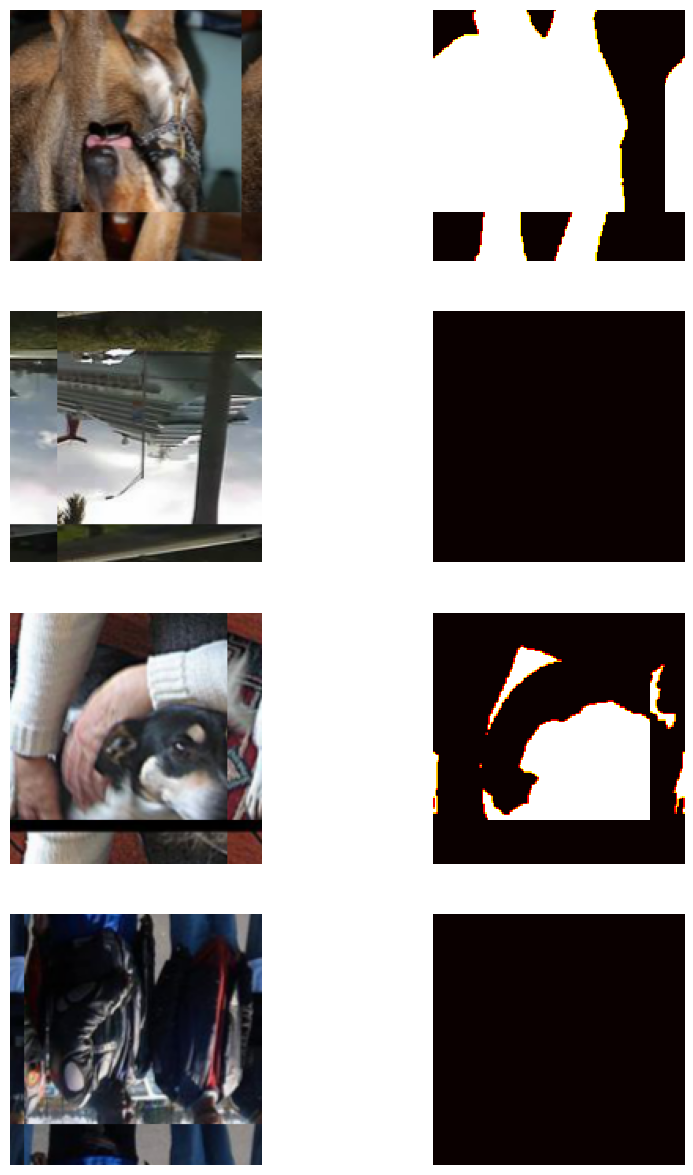

In [69]:
sample, label = next(train_generator)

fig, axs = plt.subplots(4, 2, figsize=(10, 15))
for i in range(4):

  sample1=sample[i]
  label1=label[i]

  sample1=sample1*255
  sample1=sample1.astype(int)
  axs[i][0].imshow(sample1)
  axs[i][0].axis('off')
  axs[i][1].imshow(label1, cmap='hot', interpolation='nearest')
  axs[i][1].axis('off')


### Model és kiértékelés

In [14]:
!pip install segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

In [63]:
from keras.layers.attention.multi_head_attention import activation
from segmentation_models import Unet,FPN
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score
import math

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_checkpoint.h5',
    save_weights_only=True,
    save_best_only=True,
    monitor='val_iou_score',
    mode='max',
    verbose=1
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_iou_score',
    patience=5,
    mode='max',
    verbose=1
)

steps_per_epoch = math.ceil(xs_train.shape[0] / batch_size)
validation_steps = math.ceil(xs_val.shape[0] / batch_size)

base_model = Unet(backbone_name='mobilenetv2', input_shape=(160, 160, 3), encoder_weights='imagenet',encoder_freeze=True)

x = base_model.output
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Dropout(0.5)(x)

output_layer = Conv2D(1, (1, 1), activation='sigmoid')(x)

model = Model(base_model.inputs,output_layer)

model.compile(optimizer='adam', loss=bce_jaccard_loss,metrics=[iou_score])

history = model.fit(train_generator, steps_per_epoch=steps_per_epoch,
                    validation_data=val_generator, validation_steps=validation_steps,
                    epochs=30,callbacks=[checkpoint_callback, early_stopping_callback])


Epoch 1/30
10/10 [==============================] - ETA: 0s - loss: 1.2405 - iou_score: 0.2035
Epoch 1: val_iou_score improved from -inf to 0.25575, saving model to model_checkpoint.h5
10/10 [==============================] - 36s 814ms/step - loss: 1.2405 - iou_score: 0.2035 - val_loss: 1.2441 - val_iou_score: 0.2557
Epoch 2/30
10/10 [==============================] - ETA: 0s - loss: 1.0663 - iou_score: 0.2934
Epoch 2: val_iou_score did not improve from 0.25575
10/10 [==============================] - 7s 675ms/step - loss: 1.0663 - iou_score: 0.2934 - val_loss: 1.2633 - val_iou_score: 0.2352
Epoch 3/30
10/10 [==============================] - ETA: 0s - loss: 0.9510 - iou_score: 0.3436
Epoch 3: val_iou_score improved from 0.25575 to 0.34553, saving model to model_checkpoint.h5
10/10 [==============================] - 6s 662ms/step - loss: 0.9510 - iou_score: 0.3436 - val_loss: 1.1552 - val_iou_score: 0.3455
Epoch 4/30
10/10 [==============================] - ETA: 0s - loss: 0.9466 - iou

In [73]:


loss, iou = model.evaluate(xs_test/255, ys_test)

4/4 [==============================] - 0s 102ms/step - loss: 0.7182 - iou_score: 0.6346


Text(0.5, 1.0, 'val_loss')

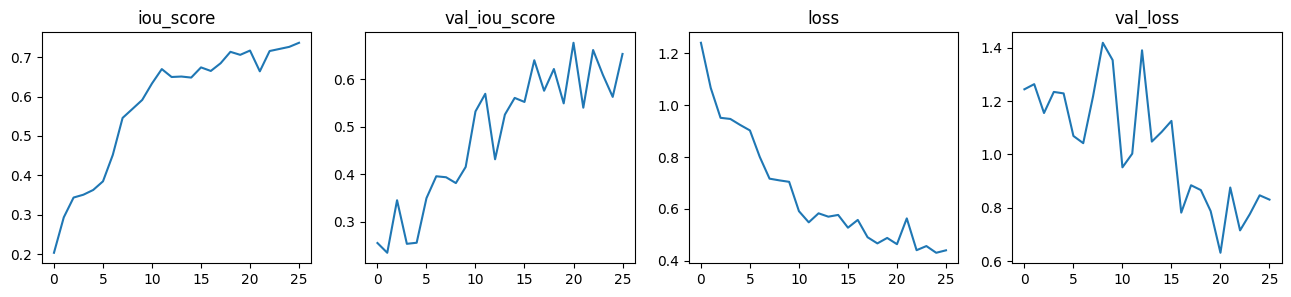

In [71]:
fig,axs=plt.subplots(1,4,figsize=(16,3))
axs[0].plot(history.history['iou_score'])
axs[0].set_title('iou_score')
axs[1].plot(history.history['val_iou_score'])
axs[1].set_title('val_iou_score')
axs[2].plot(history.history['loss'])
axs[2].set_title('loss')
axs[3].plot(history.history['val_loss'])
axs[3].set_title('val_loss')

### Néhány predkició kirajzolása

1/1 [==============================] - 0s 51ms/step


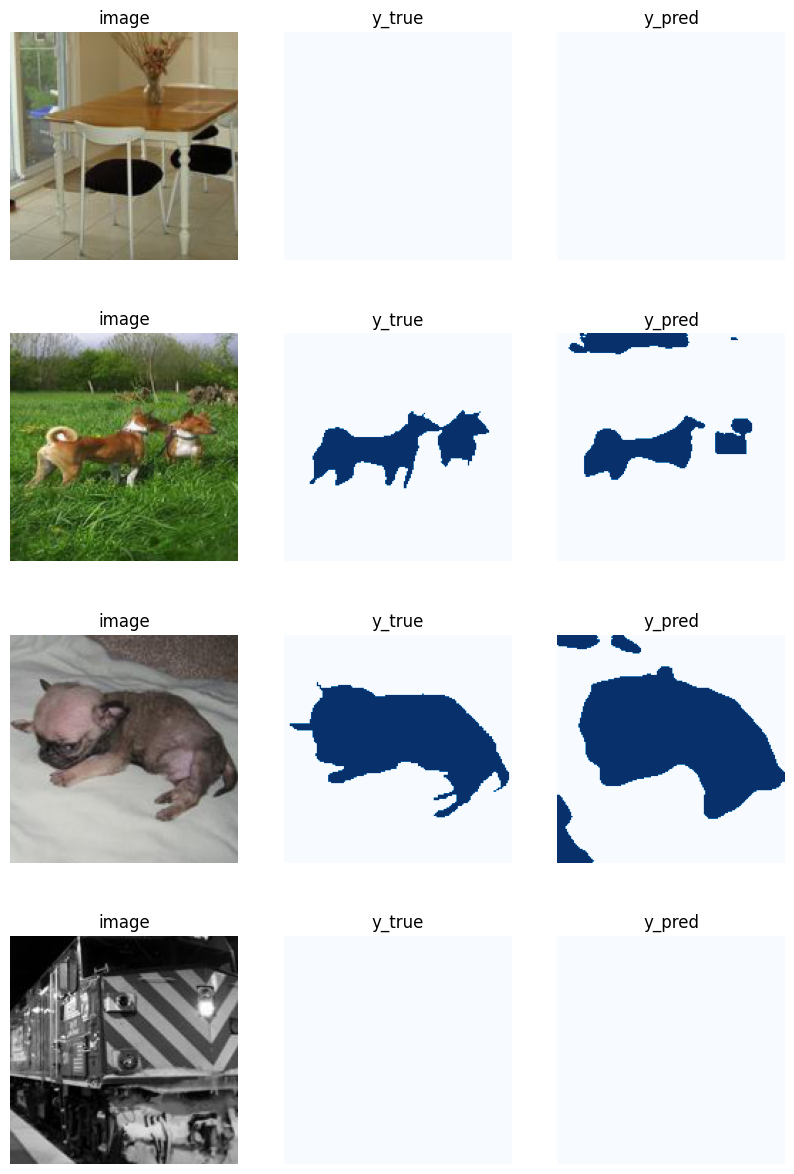

In [70]:
fig, axs = plt.subplots(4, 3, figsize=(10, 15))
preds=model.predict((xs_test[:4] / 127.5 -1))
for i in range(4):

  sample1=xs_test[i]

  label1=ys_test[i]

  pred1=preds[i]
  pred1[pred1>=0.5]=1
  pred1[pred1<0.5]=0
  axs[i][0].imshow(sample1)
  axs[i][0].axis('off')
  axs[i][0].set_title('image')
  axs[i][1].imshow(label1, cmap='Blues')
  axs[i][1].axis('off')
  axs[i][1].set_title('y_true')
  axs[i][2].imshow(pred1, cmap='Blues')
  axs[i][2].axis('off')
  axs[i][2].set_title('y_pred')